In [1]:
%matplotlib inline
import geopandas as gpd
import h5pyd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

from utils import *


In this notebook I was getting started with NSRDB data, including some code copied from their example notebooks. ([Link](https://github.com/NREL/hsds-examples))

In [2]:
# Open the desired year of nsrdb data
DATA_YEAR = 2016
nsrdb_year = h5pyd.File(f"/nrel/nsrdb/v3/nsrdb_{DATA_YEAR}.h5", 'r')
ghi = nsrdb_year['ghi']

In [3]:
# From NSRDB Docs:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site is using a KDtree
dset_coords = nsrdb_year['coordinates'][...]
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

## Select Lat Long

In [4]:
site = SITES['Fort Ross']
siteLocation = site['loc']
site_idx = nearest_site(tree, siteLocation[0], siteLocation[1] )

print(f"Desired Coordinates: {site['name']}\t {siteLocation}")
print("Coordinates of nearest point: \t {}".format(dset_coords[site_idx]))
print("Site index: \t\t {}".format(site_idx))

Desired Coordinates: Fort Ross	 (38.51265, -123.24647)
Coordinates of nearest point: 	 [  38.53 -123.26]
Site index: 		 131123


### Sanity Check for Selected Lat/Long

C:\Users\buckb\AppData\Local\Temp\ipykernel_17084\3482203708.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


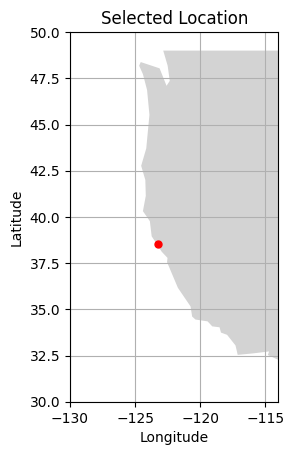

In [5]:
# Load a map of the US
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_map = gdf[gdf.name == "United States of America"]

# Plot the map
fig, ax = plt.subplots()
us_map.plot(ax=ax, color='lightgrey')

# Adjust the plot limits to focus on California
ax.set_xlim([-130, -114])
ax.set_ylim([30, 50])

# Plot the latitude and longitude as a point on the map
lat, lon = siteLocation
plt.plot(lon, lat, marker='o', color='red', markersize=5)
plt.title('Selected Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

In [6]:
# Load the NSRDB year of ghi data into a panda series
nsrdb_timestamps = pd.to_datetime(nsrdb_year['time_index'][...].astype(str))
time_index = pd.DatetimeIndex(nsrdb_timestamps).tz_localize('UTC').tz_convert(site['tz'])
ghi_series = pd.Series(data=ghi[:, site_idx], index=time_index)

Text(0.5, 1.0, 'GHI in Fort Ross in 2016')

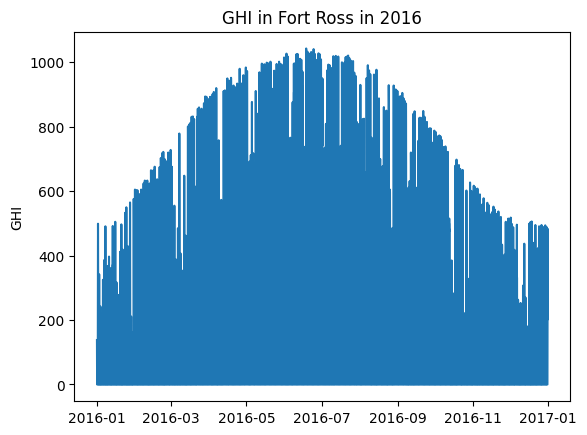

In [7]:
plt.plot(ghi_series.index, ghi_series)
plt.ylabel("GHI")
plt.title(f"GHI in {site['name']} in {DATA_YEAR}")

In [8]:
DATA_MONTH = '06'
DATA_DAY = '07'
selected_date = f'{DATA_YEAR}-{DATA_MONTH}-{DATA_DAY}'
day_ghi = ghi_series[selected_date]

month_padded = get_month_padded(DATA_YEAR, DATA_MONTH)
tide_series = get_noaa_tide_preds(site, month_padded)

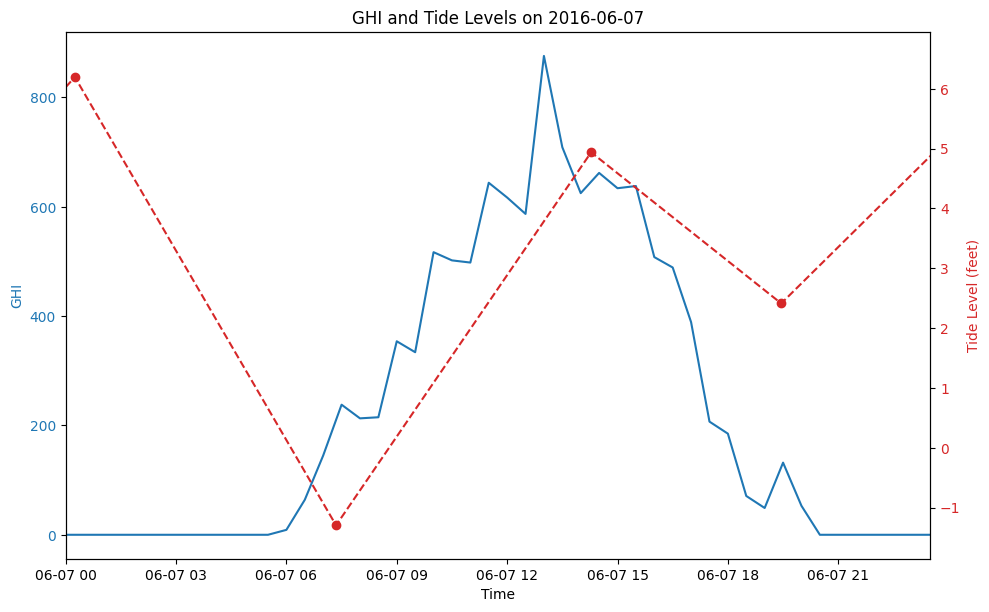

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GHI data
ax1.plot(day_ghi.index, day_ghi, label='GHI', color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('GHI', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xlim(day_ghi.index[0], day_ghi.index[-1])

# Create a secondary y-axis for tide data
ax2 = ax1.twinx()
ax2.plot(tide_series.index, tide_series, label='Tide Level', color='tab:red', marker='o', linestyle='--')
ax2.set_ylabel('Tide Level (feet)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')


# Optionally, add a legend or more labels
fig.tight_layout()
plt.title(f"GHI and Tide Levels on {selected_date}")
plt.show()